# Nonisotropic Noise

May 11, 2022

The goal in this notebook is to run a few examples of _non-isotropic noise_ with REINFORCE. How will our flow field metric look? Will the updates follow the true gradient? Or will we have to take into account the covariance structure as well?

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# analysis
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.linear_model import LinearRegression
from scipy import stats, interpolate
from scipy import linalg as LA
from scipy.ndimage.filters import uniform_filter1d

# miscellaneous
from tqdm import tqdm
from itertools import cycle
from copy import deepcopy

import logging
import warnings
import dataclasses
from dataclasses import dataclass
from typing import Optional, List

import sys
sys.path.append("../..")

In [2]:
from rnn import RNNparams, RNN
from task import Task
from simulation import Simulation
from algorithms.bptt import BPTT
from algorithms.rflo import RFLO
from algorithms.reinforce import REINFORCE
from algorithms.track_vars import TrackVars

from utils.plotting import plot_trained_trajectories
from utils.metric import cos_sim, return_norm_and_angle
from utils.functions import choose_aligned_matrix

from utils.metric import cos_sim, flow_field_data, flow_field_predicted, calculate_flow_field_correlation


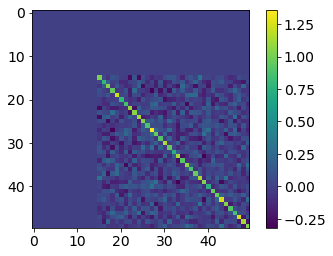

In [27]:
# Example covariance matrix

# construct a positive semidefinite matrix
c = np.random.randn(50,75)/np.sqrt(75) # number of neurons x number of samples
c[0:15] *=0.001
C = c @ c.T


plt.imshow(C)
plt.colorbar()
plt.show()

In [28]:
trial_duration = 20
n_in=4
frac_on = 1

x_tonic = 0.0*np.ones((trial_duration, n_in)) # shape 20 x 4 i.e. time x channel
x_pulse1 = x_tonic.copy()
x_pulse2 = x_tonic.copy()
x_pulse3 = x_tonic.copy()
x_pulse4 = x_tonic.copy()
x_pulse1[0:int(trial_duration*frac_on),0] = 1
x_pulse2[0:int(trial_duration*frac_on),1] = 1
x_pulse3[0:int(trial_duration*frac_on),2] = 1
x_pulse4[0:int(trial_duration*frac_on),3] = 1

task1 = Task(x_in=x_pulse1,y_target=np.asarray([[1],[1]]))
task2 = Task(x_in=x_pulse2,y_target=np.asarray([[-1],[1]]))
task3 = Task(x_in=x_pulse3,y_target=np.asarray([[1],[-1]]))
task4 = Task(x_in=x_pulse4,y_target=np.asarray([[-1],[-1]]))

# REINFORCE with Nonisotropic noise

4it [00:00, 33.89it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.0
sig_rec: 0.25
sig_out: 0.01
tau_rec: 10
dt: 1.0
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
g_in: 2.0
g_rec: 1.5
g_out: 2.0
g_fb: 2.0
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: 0.8
dt_vel: 0.1
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7fa3d881fa68>


500it [00:07, 67.82it/s]
8it [00:00, 73.73it/s]

M norm: 1.17	 M angle: 0.41, 9 iterations
w_out1 norm: 1.61	 w_out vs. w_out1 angle: 0.39
w_m norm: 1.17	 w_out1 vs. w_m angle: 0.41
w_m norm: 1.77	 w_out vs. w_m angle: 0.18
w_out1@C.T norm: 1.71	 w_out1@C.T vs. w_out0 angle: 0.28

1000it [00:12, 76.62it/s]
2000it [00:36, 52.71it/s]
1000it [00:18, 54.42it/s]


AR early fit 0.985, late fit 0.987


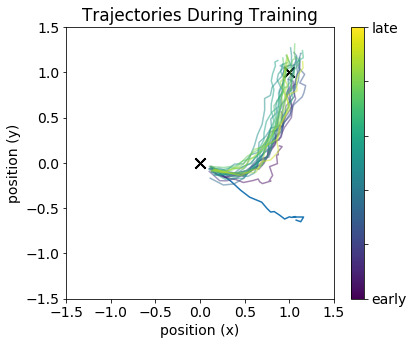

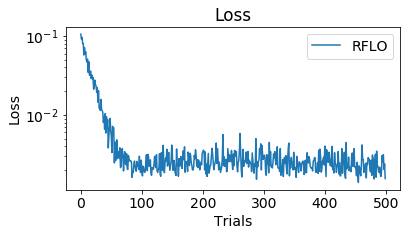

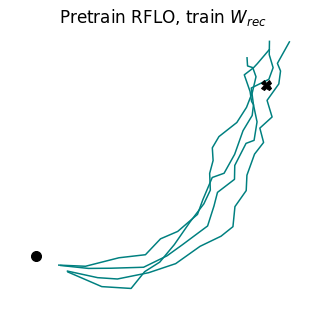

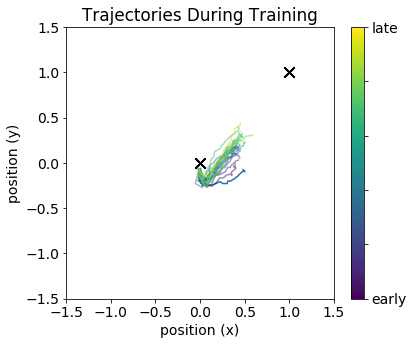

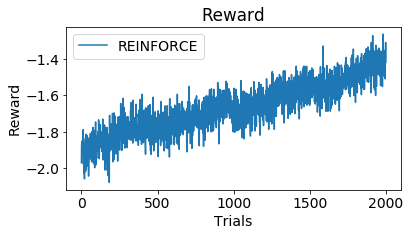

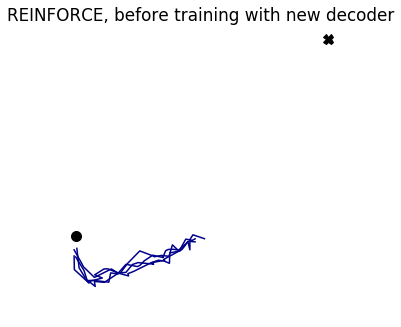

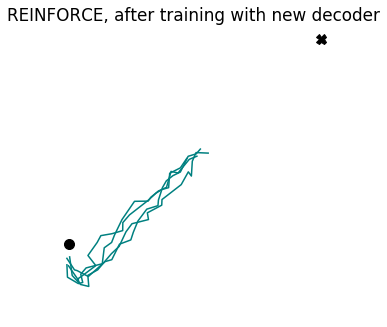

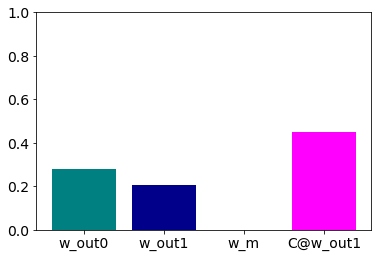

similarity DeltaC2 & DeltaC2_pred_w_out: 0.042
similarity DeltaC2 & DeltaC2_pred_w_out1: 0.007
similarity DeltaC2 & DeltaC2_pred_w_m: 0.009


>> CTRL DeltaC2 & CTRL_h2_pre: -0.187
>> CTRL DeltaC2 & CTRL_h2_post: -0.035
>> CTRL DeltaC2 & CTRL_dW2_w_out_h2_post: 0.042
>> CTRL DeltaC2 & CTRL_dW2_w_out1_h2_post: 0.007
>> CTRL DeltaC2 & CTRL_dW2_w_m_h2_post: 0.009




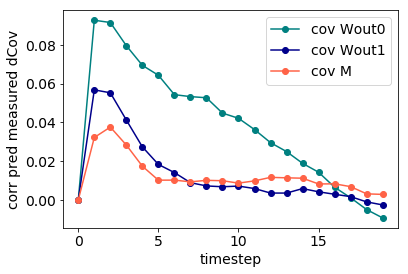

5it [00:00, 45.32it/s]

M norm: 1.20	 M angle: 0.40, 2 iterations
w_out1 norm: 1.61	 w_out vs. w_out1 angle: 0.39
w_m norm: 1.20	 w_out1 vs. w_m angle: 0.40
w_m norm: 1.63	 w_out vs. w_m angle: 0.34
w_out1@C.T norm: 1.82	 w_out1@C.T vs. w_out0 angle: 0.30

1000it [00:14, 78.31it/s]
2000it [00:34, 57.30it/s]
1000it [00:17, 57.99it/s]


AR early fit 0.985, late fit 0.987


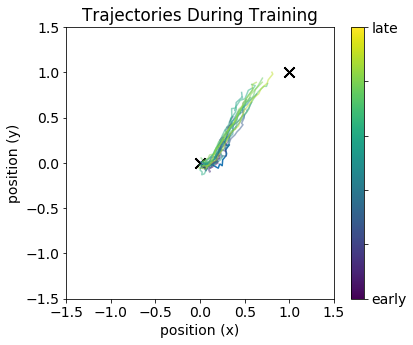

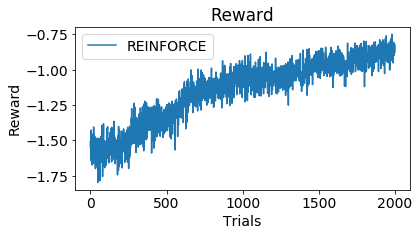

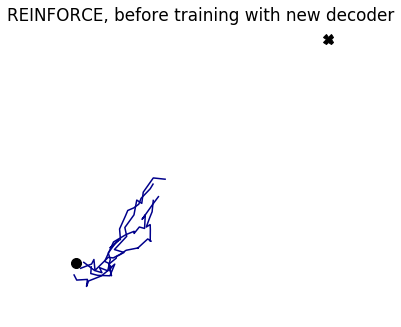

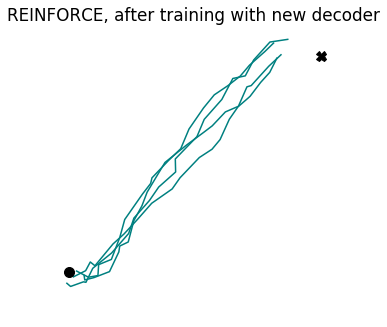

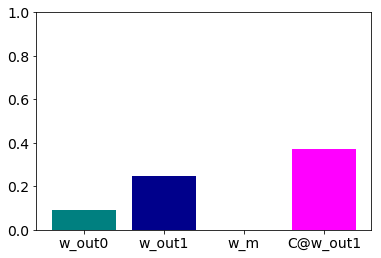

similarity DeltaC2 & DeltaC2_pred_w_out: 0.023
similarity DeltaC2 & DeltaC2_pred_w_out1: 0.029
similarity DeltaC2 & DeltaC2_pred_w_m: -0.017


>> CTRL DeltaC2 & CTRL_h2_pre: -0.266
>> CTRL DeltaC2 & CTRL_h2_post: -0.108
>> CTRL DeltaC2 & CTRL_dW2_w_out_h2_post: 0.021
>> CTRL DeltaC2 & CTRL_dW2_w_out1_h2_post: 0.027
>> CTRL DeltaC2 & CTRL_dW2_w_m_h2_post: -0.017




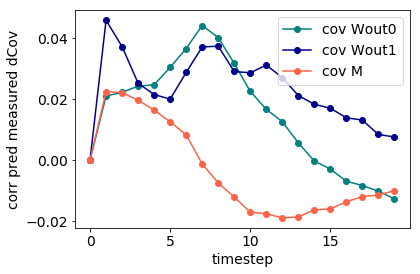

6it [00:00, 51.11it/s]

M norm: 1.16	 M angle: 0.40, 21 iterations
w_out1 norm: 1.61	 w_out vs. w_out1 angle: 0.41
w_m norm: 1.16	 w_out1 vs. w_m angle: 0.40
w_m norm: 1.81	 w_out vs. w_m angle: 0.09
w_out1@C.T norm: 1.85	 w_out1@C.T vs. w_out0 angle: 0.26

1000it [00:14, 67.36it/s]
2000it [00:33, 60.02it/s]
1000it [00:13, 74.57it/s]


AR early fit 0.985, late fit 0.987


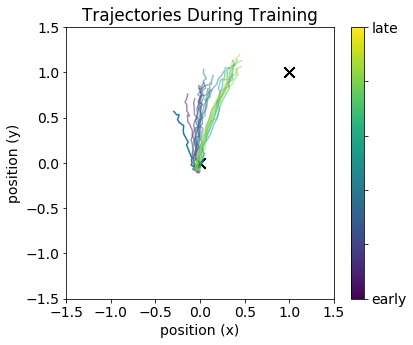

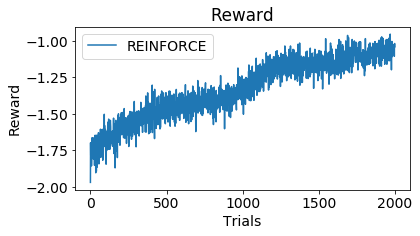

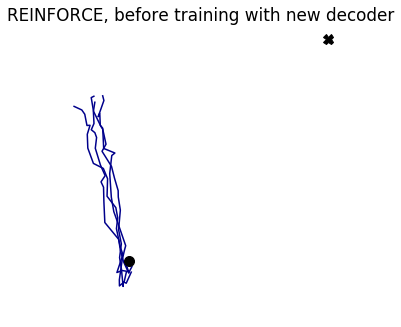

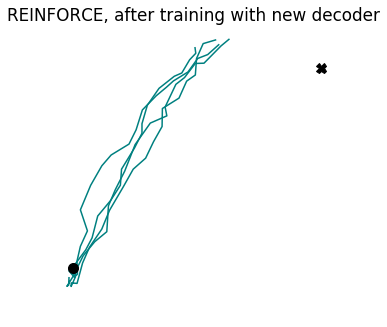

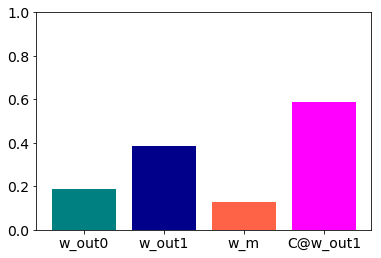

similarity DeltaC2 & DeltaC2_pred_w_out: 0.020
similarity DeltaC2 & DeltaC2_pred_w_out1: 0.078
similarity DeltaC2 & DeltaC2_pred_w_m: -0.045


>> CTRL DeltaC2 & CTRL_h2_pre: -0.254
>> CTRL DeltaC2 & CTRL_h2_post: -0.077
>> CTRL DeltaC2 & CTRL_dW2_w_out_h2_post: 0.019
>> CTRL DeltaC2 & CTRL_dW2_w_out1_h2_post: 0.075
>> CTRL DeltaC2 & CTRL_dW2_w_m_h2_post: -0.045




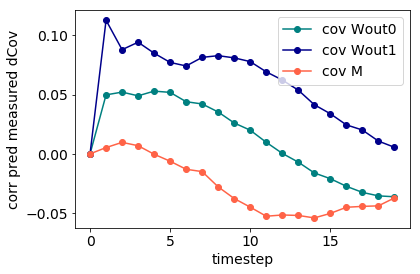

5it [00:00, 44.87it/s]

M norm: 1.15	 M angle: 0.39, 1 iterations
w_out1 norm: 1.60	 w_out vs. w_out1 angle: 0.40
w_m norm: 1.15	 w_out1 vs. w_m angle: 0.39
w_m norm: 1.74	 w_out vs. w_m angle: 0.18
w_out1@C.T norm: 1.74	 w_out1@C.T vs. w_out0 angle: 0.29

1000it [00:12, 78.63it/s]
2000it [00:28, 70.23it/s]
1000it [00:13, 73.53it/s]


AR early fit 0.985, late fit 0.987


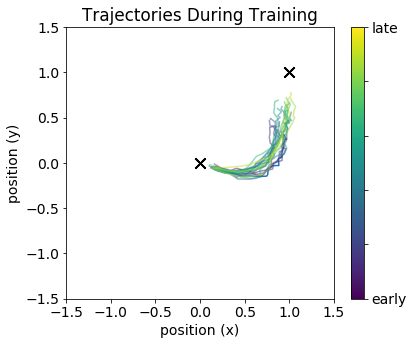

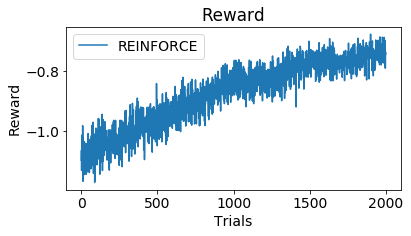

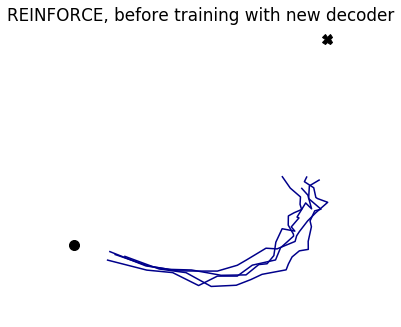

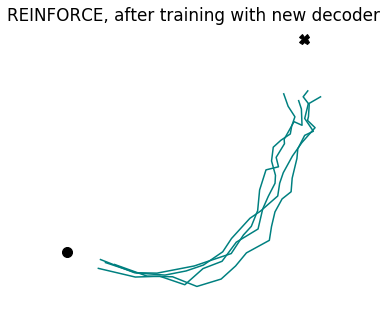

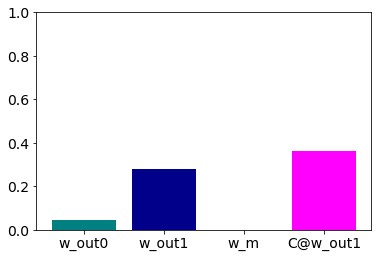

similarity DeltaC2 & DeltaC2_pred_w_out: -0.006
similarity DeltaC2 & DeltaC2_pred_w_out1: -0.019
similarity DeltaC2 & DeltaC2_pred_w_m: -0.000


>> CTRL DeltaC2 & CTRL_h2_pre: -0.222
>> CTRL DeltaC2 & CTRL_h2_post: -0.067
>> CTRL DeltaC2 & CTRL_dW2_w_out_h2_post: -0.005
>> CTRL DeltaC2 & CTRL_dW2_w_out1_h2_post: -0.019
>> CTRL DeltaC2 & CTRL_dW2_w_m_h2_post: -0.000




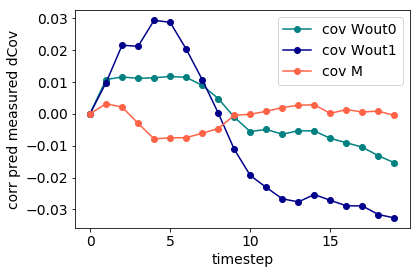

In [30]:
# Set RNN Parameters
params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=10,
               eta_in=0.1,eta_rec=0.1,eta_out=0.1,
               sig_in=0.0,sig_rec=0.25,sig_out=0.01,
               velocity_transform=False, tau_vel = 0.8, dt_vel = 0.1,
               rng=np.random.RandomState(72))
params.print_params()

# Initialize RNN, train with RFLO
net0 = RNN(params,sig_rec_covariance=C)
sim0 = Simulation(net0)
rflo = RFLO(net0,apply_to=['w_rec'],online=False)
sim0.run_session(n_trials=500, tasks=[task1], learn_alg=[rflo], probe_types=['loss'], plot=True, plot_freq=20)

fig0 = plot_trained_trajectories(sim=sim0, tasks=[task1],title='Pretrain RFLO, train '+r'$W_{rec}$')



""" Average over multiple seeds """
seeds = [1,2,33,44] #,1,12,54,72,81]
overlaps = [0.4]
n_changes = [60]



stats = {}
stats['corr1'] = []
stats['corr2'] = []
stats['corr3'] = []
stats['corr4'] = [] # for nonisotropic noise
stats['corrcoef'] = []


for seed in seeds:

    corr1_list = []
    corr2_list = []
    corr3_list = []
    corr4_list = []
    corrcoef_list = []


    for overlap,n_change in zip(overlaps,n_changes):
        
        w_out1 = choose_aligned_matrix(net0.w_out.copy(),n_change=n_change,overlap=overlap,rng=np.random.RandomState(seed),zero=False,tolerance=0.01,loop=1000)
        w_m = choose_aligned_matrix(w_out1,n_change=n_change,overlap=overlap,rng=np.random.RandomState(seed),zero=False,tolerance=0.01,loop=1000)

        # confirm overlap between w_out1 and w_out
        norm, angle = return_norm_and_angle(net0.w_out,w_out1)
        print('\nw_out1 norm: {:.2f}'.format(norm) + '\t w_out vs. w_out1 angle: {:.2f}'.format(angle),end='')

        # confirm overlap between w_out1 and w_m
        norm, angle = return_norm_and_angle(w_out1,w_m)
        print('\nw_m norm: {:.2f}'.format(norm) + '\t w_out1 vs. w_m angle: {:.2f}'.format(angle),end='')

        # confirm overlap between w_out and w_m
        norm, angle = return_norm_and_angle(net0.w_out,w_m)
        print('\nw_m norm: {:.2f}'.format(norm) + '\t w_out vs. w_m angle: {:.2f}'.format(angle),end='')
        
        # confirm overlap between C@w_out1 and w_out
        norm, angle = return_norm_and_angle(w_out1 @ C.T,net0.w_out)
        print('\nw_out1@C.T norm: {:.2f}'.format(norm) + '\t w_out1@C.T vs. w_out0 angle: {:.2f}'.format(angle),end='')
        
        
        
        
        net2_pre = RNN(params,sig_rec_covariance=C)
        net2_pre.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy())
        net2_pre.set_weights(w_out = w_out1)
        net2_pre.set_weights(w_m = 0*w_m.T) # shouldn't matter for REINFORCE

        # unfortunately I need to make a different network to maintain integrity of pre and post simulations for plotting
        net2 = RNN(params,sig_rec_covariance=C)
        net2.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy())
        net2.set_weights(w_out = w_out1)
        net2.set_weights(w_m = 0*w_m.T) # shouldn't matter for REINFORCE



        """ Track activity with new decoder, before training """

        sim2_pre = Simulation(net2_pre)
        trackvars = TrackVars(net2_pre,apply_to=[]) 
        sim2_pre.run_session(n_trials=1000, tasks=[task1], learn_alg=[trackvars], probe_types=['h','err'], plot=False, plot_freq=10)
        #fig = plot_trained_trajectories(sim=sim1_pre, tasks=[task1,task2,task3,task4],title='RFLO, before training with new decoder')

        """ Train with new decoder """

        sim2_train = Simulation(net2)
        reinforce = REINFORCE(net2,apply_to=['w_rec'],online=False,tau_reward=5)
        sim2_train.run_session(n_trials=2000, tasks=[task1], learn_alg=[reinforce], probe_types=['h','reward','err'], plot=True, plot_freq=100)

        """ Track activity with new decoder, after training """
        net2_post = RNN(params,sig_rec_covariance=C)
        net2_post.set_weights(w_in=net2.w_in.copy(), w_rec=net2.w_rec.copy())
        net2_post.set_weights(w_out = net2.w_out)
        net2_post.set_weights(w_m = 0*net2.w_m) # shouldn't matter for REINFORCE

        sim2_post = Simulation(net2_post)
        trackvars = TrackVars(net2_post,apply_to=[]) 
        sim2_post.run_session(n_trials=1000, tasks=[task1], learn_alg=[trackvars], probe_types=['h','err'], plot=False, plot_freq=10)

        
        fig = plot_trained_trajectories(sim=sim2_pre, tasks=[task1],title='REINFORCE, before training with new decoder')

        fig = plot_trained_trajectories(sim=sim2_post, tasks=[task1],title='REINFORCE, after training with new decoder')
        
        
        """ Calculate F fields """
        F_early, score_early = flow_field_data(sim2_pre.session_probes['h'])
        F_late, score_late = flow_field_data(sim2_post.session_probes['h'])

        print('AR early fit {:.3f}, late fit {:.3f}'.format(score_early,score_late))

        Fdata = F_late - F_early

        # separate train and test data from sim1_train
        n_total = len(sim2_train.session_probes['h'])
        n_train = int(0.5 * n_total)
        idx_train = np.random.RandomState(1975+seed).choice(np.arange(0,n_total),size=n_train,replace=False).astype(int)
        idx_test = np.arange(0,n_total)[~idx_train].astype(int)
        #idx_test=idx_train

        h_train = np.asarray(sim2_train.session_probes['h'])[idx_train,:,:,:]
        err_train = np.asarray(sim2_train.session_probes['err'])[idx_train,:,:,:]

        Fpred_w_out = flow_field_predicted(net0.w_out,err_train,h_train)
        Fpred_w_out1 = flow_field_predicted(w_out1,err_train,h_train)
        Fpred_w_m = flow_field_predicted(w_m,err_train,h_train)
        Fpred_cov_w_out1 = flow_field_predicted(w_out1@C.T,err_train,h_train) # nonisotropic noise, wout1 is tranposed inside function

        h_test = np.asarray(sim2_train.session_probes['h'])[idx_test,:,:,:]

        corr1 = calculate_flow_field_correlation(Fpred_w_out,Fdata,h_test) # could also sample sim_test
        corr1_list.append(corr1)

        corr2 = calculate_flow_field_correlation(Fpred_w_out1,Fdata,h_test) # could also sample sim_test
        corr2_list.append(corr2)

        corr3 = calculate_flow_field_correlation(Fpred_w_m,Fdata,h_test) # could also sample sim_test
        corr3_list.append(corr3)
        
        corr4 = calculate_flow_field_correlation(Fpred_cov_w_out1,Fdata,h_test) # could also sample sim_test
        corr4_list.append(corr4)
        
        fig,ax = plt.subplots(1,1)
        plt.bar([0,1,2,3],[corr1,corr2,corr3,corr4],tick_label=['w_out0','w_out1','w_m','C@w_out1'],color=['teal','darkblue','tomato','magenta'])
        plt.ylim([0,1])
        plt.show()
        
        
        
        
        
        
    # update
    stats['corr1'].append(corr1_list)
    stats['corr2'].append(corr2_list)
    stats['corr3'].append(corr3_list)
    stats['corr4'].append(corr4_list)
    #stats['corrcoef'].append(corrcoef_list)


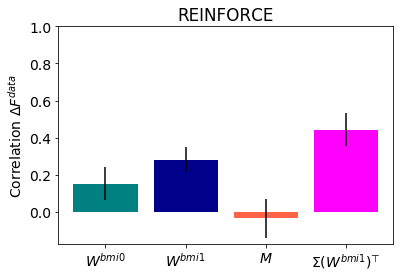

In [31]:
paper = False
save = False

""" take mean and std """
mn1 = np.mean(np.asarray(stats['corr1']),axis=0)[0]
mn2 = np.mean(np.asarray(stats['corr2']),axis=0)[0]
mn3 = np.mean(np.asarray(stats['corr3']),axis=0)[0]
mn4 = np.mean(np.asarray(stats['corr4']),axis=0)[0]
std1 = np.std(np.asarray(stats['corr1']),axis=0)[0]
std2 = np.std(np.asarray(stats['corr2']),axis=0)[0]
std3 = np.std(np.asarray(stats['corr3']),axis=0)[0]
std4 = np.std(np.asarray(stats['corr4']),axis=0)[0]

fig,ax = plt.subplots(1,1)
plt.bar([0,1,2,3],[mn1,mn2,mn3,mn4],yerr=[std1,std2,std3,std4],tick_label=[r'$W^{bmi0}$',r'$W^{bmi1}$',r'$M$',r'$\Sigma (W^{bmi1})^\top$'],color=['teal','darkblue','tomato','magenta'])

plt.title('REINFORCE')
plt.ylabel('Correlation '+r'$\Delta F^{data}$')
#plt.xlabel('Predicted '+r'$\Delta F$')
plt.ylim(top=1)

if paper:
    fig,ax = paper_format(fig=fig,ax=ax,xlabels=None,ylabels=None,ticksize=10,linewidth=2,ylim=[0,0.6],figsize=(2,2.25))

    

plt.show()

if save:
    fig.savefig(folder+'reinforce-dF-correlation-nonisotropic.pdf')

In [7]:
flow_field_predicted??

Signature: flow_field_predicted(W, err_list, h_list)
Source:   
def flow_field_predicted(W,err_list,h_list):
    
    """ Prediction change in flow field due to learning
    
    Args
    ----
    W (np.array): matrix used to calculate flow field based on learning
    err_list: list of np.arrays, each item is err for a trial
    h_list: list of np.arrays, each item is h for a trial
    
    TO DO: Maybe consider alternative learning rule updates here?
    """
    
    n_steps = h_list[0].squeeze().shape[0]
    n_neurons = h_list[0].squeeze().shape[1]
    
    dF = np.zeros((n_neurons,n_neurons))
    
    # loop through trials
    for trial in range(len(h_list)):
        
        # loop through timesteps
        for t in range(n_steps):
            
            # this assumes cumulative weight update
            dF += np.outer(W.T @ err_list[trial].squeeze()[t], h_list[trial].squeeze()[t])
            
            
    return dF
File:      ~/Documents/Code/rnn-learning/utils/metric.py
T